**Step 1: Installing required libraries**

In [1]:
# Installing Hugging Face + Streamlit
!pip install --upgrade transformers datasets scikit-learn torch




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2


In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments



**Step 2: Loading dataset**

In [4]:
from google.colab import files

uploaded = files.upload()



Saving go_emotions_dataset.csv.zip to go_emotions_dataset.csv.zip


**Step 3: Import Libraries**

In [5]:
import pandas as pd

df = pd.read_csv("go_emotions_dataset.csv.zip")
print(df.head())


        id                                               text  \
0  eew5j0j                                    That game hurt.   
1  eemcysk   >sexuality shouldn’t be a grouping category I...   
2  ed2mah1     You do right, if you don't care then fuck 'em!   
3  eeibobj                                 Man I love reddit.   
4  eda6yn6  [NAME] was nowhere near them, he was by the Fa...   

   example_very_unclear  admiration  amusement  anger  annoyance  approval  \
0                 False           0          0      0          0         0   
1                  True           0          0      0          0         0   
2                 False           0          0      0          0         0   
3                 False           0          0      0          0         0   
4                 False           0          0      0          0         0   

   caring  confusion  ...  love  nervousness  optimism  pride  realization  \
0       0          0  ...     0            0         0      0 

**Step 4: Define Labels**

In [6]:
# Emotion label columns (all except text)
label_cols = [c for c in df.columns if c not in ["text"]]
num_labels = len(label_cols)

print("Number of labels:", num_labels)
print("Labels:", label_cols[:10])  # showing first 10


Number of labels: 30
Labels: ['id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity']


**Step 5: Data Preparation (Train/Val/Test split + Tokenization + Dataset)**

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import torch

# selecting label columns (all except text/id/extra columns)
label_cols = [c for c in df.columns if c not in ["text", "id", "example_very_unclear"]]

# converting labels to float32 numpy array
labels = df[label_cols].values.astype("float32")

# Train/Val/Test Split

# First split into train + temp (val+test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"].tolist(),
    labels,
    test_size=0.2,   # 20% goes to val+test
    random_state=42
)

# Now split temp into validation + test (10% each overall)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,   # half of 20% → 10% test, 10% val
    random_state=42
)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Custom Dataset Class
class GoEmotionsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

# Final datasets
train_dataset = GoEmotionsDataset(train_encodings, train_labels)
val_dataset   = GoEmotionsDataset(val_encodings, val_labels)
test_dataset  = GoEmotionsDataset(test_encodings, test_labels)

# Redefine num_labels based on the actual number of label columns
num_labels = len(label_cols)

print("Datasets ready")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Datasets ready
Train: 168980, Val: 21122, Test: 21123


**Step 6: Load DistilBERT Model**

In [9]:

from transformers import DistilBertForSequenceClassification

num_labels = len(label_cols)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification"
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



**Step 7: Training Arguments**

In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    do_eval=True,
    report_to="none"
)


**Step 8: Trainer API**

In [11]:
from transformers import Trainer
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (logits > 0).astype(int)   # threshold for multi-label
    f1 = f1_score(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# training model
trainer.train()


/tmp/ipython-input-1853162627.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.375400
200,0.177700
300,0.162300
400,0.160500
500,0.159700
600,0.151200
700,0.147000
800,0.141800
900,0.139200
1000,0.135200


TrainOutput(global_step=21124, training_loss=0.11613233234818698, metrics={'train_runtime': 4465.9533, 'train_samples_per_second': 75.675, 'train_steps_per_second': 4.73, 'total_flos': 1.119736002072576e+16, 'train_loss': 0.11613233234818698, 'epoch': 2.0})

**Step 9: Save Model**

In [12]:
trainer.save_model("./saved_model")
tokenizer.save_pretrained("./saved_model")

print("Model and tokenizer saved to ./saved_model/")


Model and tokenizer saved to ./saved_model/


**Step 10: Testing Prediction**

In [13]:
from transformers import pipeline

emotion_classifier = pipeline(
    "text-classification",
    model="./saved_model",
    tokenizer="./saved_model",
    return_all_scores=True,
    function_to_apply="sigmoid"
)

test_text = "I feel so stressed and overwhelmed with my work."
preds = emotion_classifier(test_text)
print(preds)


Device set to use cuda:0


[[{'label': 'LABEL_0', 'score': 0.014479477889835835}, {'label': 'LABEL_1', 'score': 0.0061964369378983974}, {'label': 'LABEL_2', 'score': 0.008968973532319069}, {'label': 'LABEL_3', 'score': 0.041901230812072754}, {'label': 'LABEL_4', 'score': 0.05673789605498314}, {'label': 'LABEL_5', 'score': 0.0523773655295372}, {'label': 'LABEL_6', 'score': 0.019453145563602448}, {'label': 'LABEL_7', 'score': 0.01556929387152195}, {'label': 'LABEL_8', 'score': 0.010184664279222488}, {'label': 'LABEL_9', 'score': 0.12936897575855255}, {'label': 'LABEL_10', 'score': 0.011094707995653152}, {'label': 'LABEL_11', 'score': 0.008853286504745483}, {'label': 'LABEL_12', 'score': 0.033487897366285324}, {'label': 'LABEL_13', 'score': 0.027939457446336746}, {'label': 'LABEL_14', 'score': 0.06817910820245743}, {'label': 'LABEL_15', 'score': 0.016833411529660225}, {'label': 'LABEL_16', 'score': 0.01861557550728321}, {'label': 'LABEL_17', 'score': 0.05814627185463905}, {'label': 'LABEL_18', 'score': 0.0067018470

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [14]:
trainer.save_model("emotion_model")
tokenizer.save_pretrained("emotion_model")

print("Final model saved to ./emotion_model/")


Final model saved to ./emotion_model/


**Step 11: Evaluation**

**Step 11.1: Generate Predictions on Test Set**

In [25]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=32)  # larger batch size speeds up

all_preds = []
all_labels = []

for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
    labels = batch["labels"].numpy()

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.3).astype(int)

    all_preds.append(preds)
    all_labels.append(labels)

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

print("Predictions ready!")


Evaluating: 100%|██████████| 661/661 [35:43<00:00,  3.24s/batch]

Predictions ready!


**Step 11.2: Classification Report**

In [26]:
# Map IDs to actual emotion labels
id2label = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement",
    14: "fear", 15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}

print(classification_report(all_labels, all_preds, target_names=[id2label[i] for i in range(len(id2label))]))


                precision    recall  f1-score   support

    admiration       0.56      0.64      0.60      1735
     amusement       0.55      0.75      0.63       949
         anger       0.40      0.37      0.39       797
     annoyance       0.35      0.14      0.20      1363
      approval       0.41      0.17      0.24      1651
        caring       0.33      0.26      0.29       562
     confusion       0.35      0.19      0.25       714
     curiosity       0.37      0.54      0.44       988
        desire       0.40      0.26      0.31       397
disappointment       0.38      0.11      0.17       860
   disapproval       0.36      0.21      0.27      1173
       disgust       0.39      0.23      0.29       514
 embarrassment       0.50      0.22      0.30       237
    excitement       0.41      0.18      0.25       601
          fear       0.48      0.46      0.47       331
     gratitude       0.82      0.81      0.82      1148
         grief       0.00      0.00      0.00  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklea

**Step 11.3: Confusion Matrix (Single Emotion Example: Sadness)**

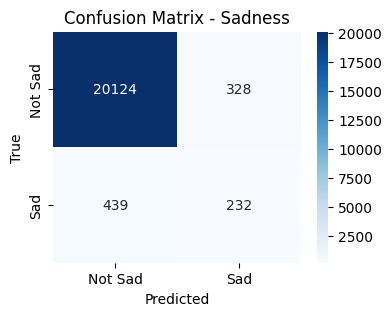

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Picking sadness index = 25
label_index = 25

cm = multilabel_confusion_matrix(all_labels, all_preds)[label_index]

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Sad", "Sad"],
            yticklabels=["Not Sad", "Sad"])
plt.title("Confusion Matrix - Sadness")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


**Step 11.4: Confusion Matrices for All Emotions**

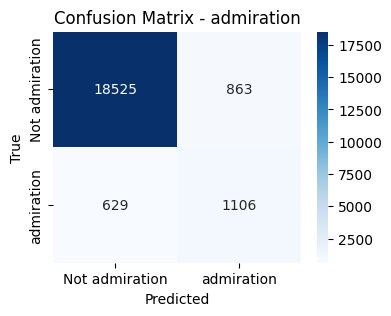

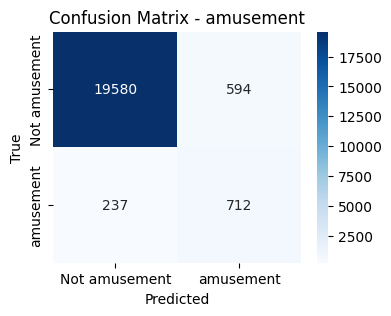

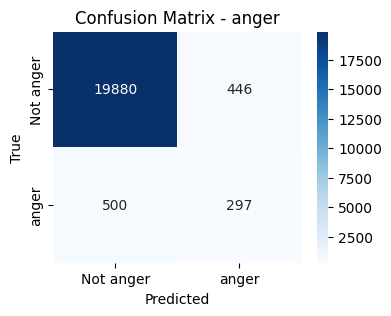

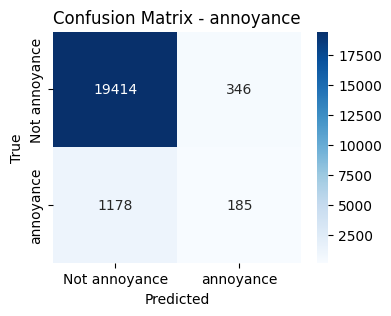

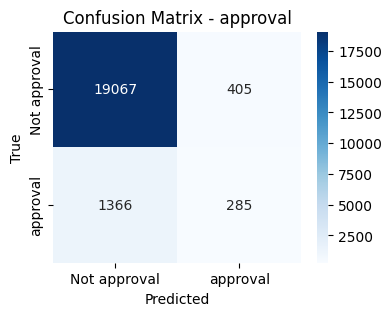

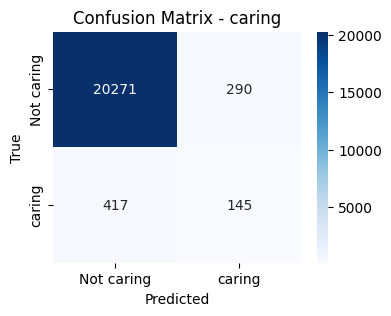

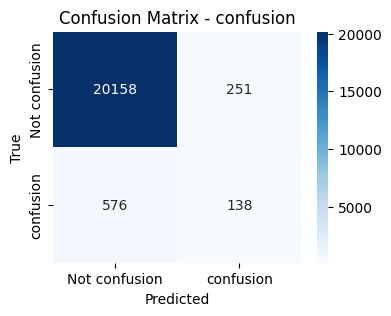

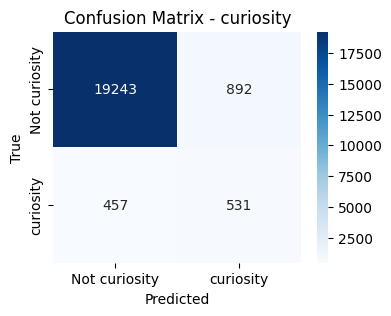

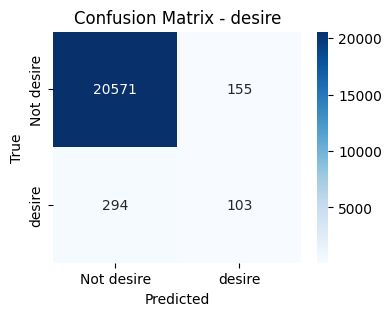

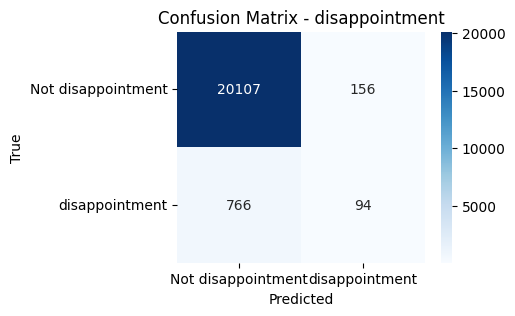

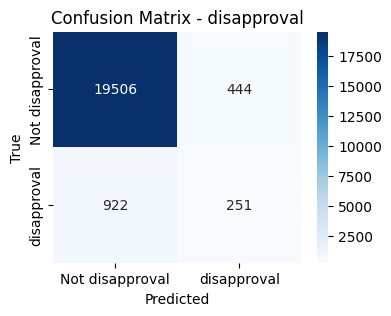

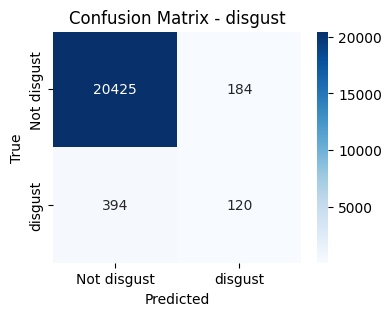

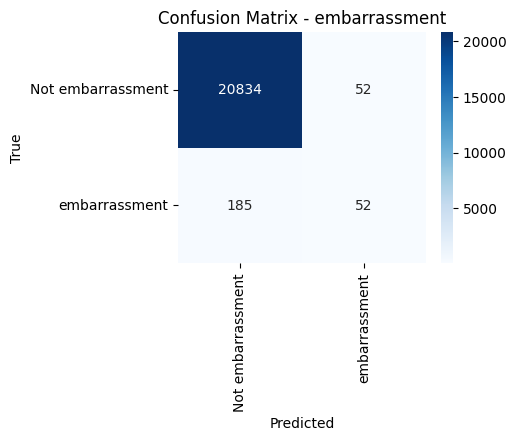

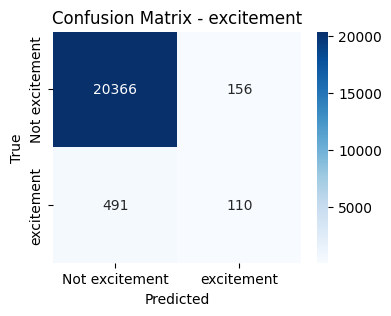

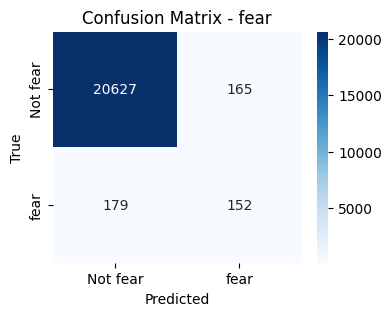

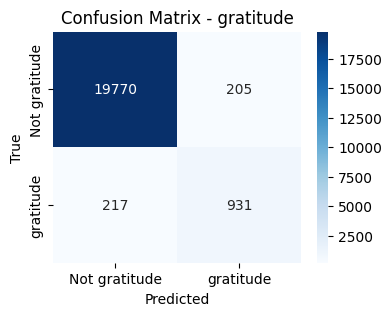

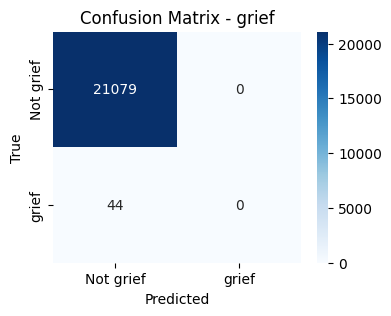

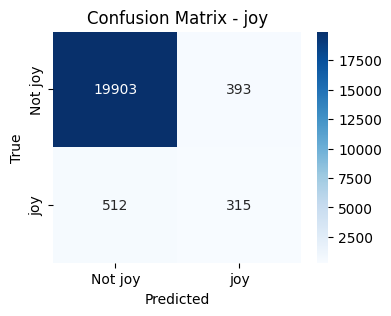

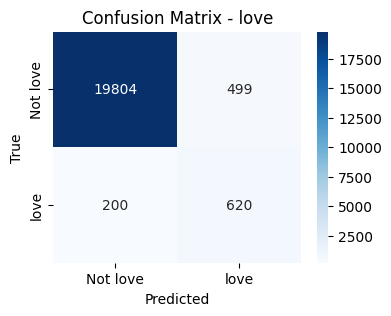

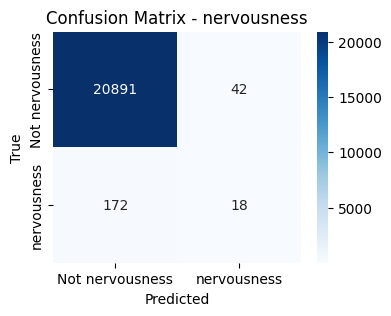

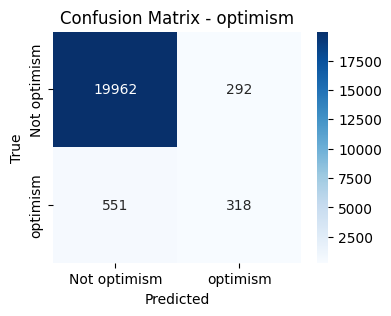

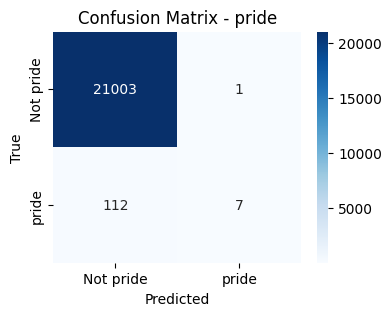

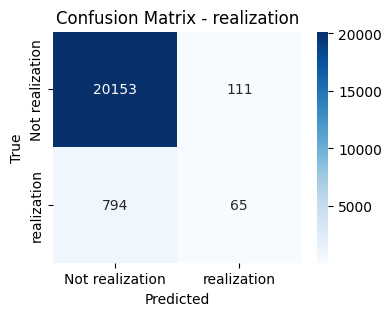

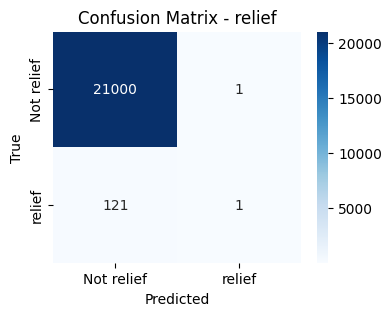

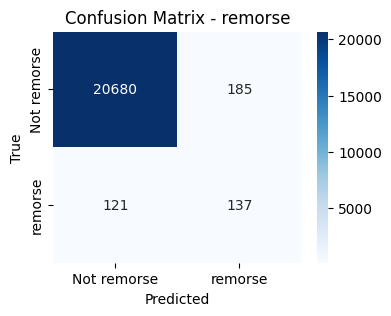

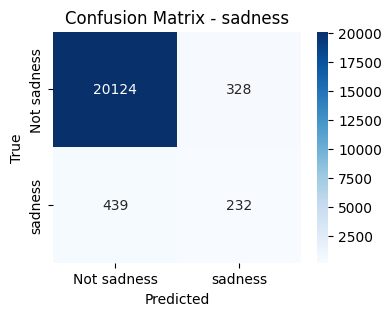

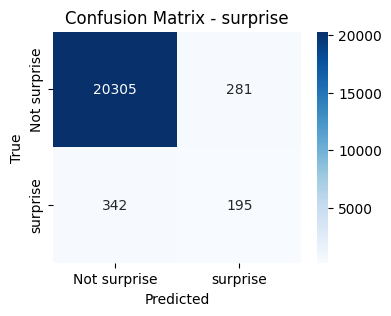

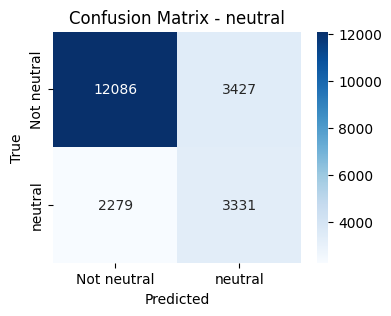

In [28]:
for idx, label in id2label.items():
    cm = multilabel_confusion_matrix(all_labels, all_preds)[idx]

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"Not {label}", label],
                yticklabels=[f"Not {label}", label])
    plt.title(f"Confusion Matrix - {label}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


**Step 12: Label Mapping**

In [29]:
# Map Hugging Face labels -> Emotion names
id2label = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement",
    14: "fear", 15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}

# Example: map a single prediction row
sample_preds = all_preds[0]  # first row predictions
mapped_emotions = [id2label[i] for i, val in enumerate(sample_preds) if val == 1]
print("Predicted emotions:", mapped_emotions)


Predicted emotions: ['admiration']


**Step 12.1: Group Emotions into Positive / Negative / Neutral**

In [30]:
# Define grouping dictionary
grouping = {
    "Positive": [
        "admiration", "amusement", "approval", "caring", "curiosity", "excitement",
        "gratitude", "joy", "love", "optimism", "pride", "relief", "surprise"
    ],
    "Negative": [
        "anger", "annoyance", "confusion", "disappointment", "disapproval",
        "disgust", "embarrassment", "fear", "grief", "nervousness", "remorse", "sadness"
    ],
    "Neutral": [
        "realization", "neutral", "desire"
    ]
}

# Reverse mapping: emotion -> group
emotion2group = {}
for group, emotions in grouping.items():
    for emo in emotions:
        emotion2group[emo] = group

# Function: convert multi-label predictions into groups
def map_to_groups(predictions, id2label, emotion2group):
    grouped_preds = []
    for row in predictions:
        emotions = [id2label[i] for i, val in enumerate(row) if val == 1]
        groups = [emotion2group[e] for e in emotions if e in emotion2group]
        grouped_preds.append(groups)
    return grouped_preds

# Applying to predictions + true labels
grouped_preds = map_to_groups(all_preds, id2label, emotion2group)
grouped_labels = map_to_groups(all_labels, id2label, emotion2group)

print("Example true groups:", grouped_labels[0])
print("Example predicted groups:", grouped_preds[0])


Example true groups: ['Positive']
Example predicted groups: ['Positive']


**Step 12.2: Re-Evaluate at Group Level**

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer

# Fiting a binarizer on 3 groups
mlb = MultiLabelBinarizer(classes=["Positive", "Negative", "Neutral"])

y_true_group = mlb.fit_transform(grouped_labels)
y_pred_group = mlb.transform(grouped_preds)

print("Classification Report (Group Level):")
print(classification_report(y_true_group, y_pred_group, target_names=mlb.classes_))


Classification Report (Group Level):
              precision    recall  f1-score   support

    Positive       0.73      0.70      0.72      9162
    Negative       0.68      0.43      0.52      6144
     Neutral       0.56      0.58      0.57      6852

   micro avg       0.66      0.59      0.62     22158
   macro avg       0.66      0.57      0.60     22158
weighted avg       0.66      0.59      0.62     22158
 samples avg       0.58      0.59      0.57     22158



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


**Step 13: Insights & Visualization**

**Step 13.1 Show Sample Predictions with Confidence Scores**

In [42]:
sample_indices = np.random.choice(len(test_texts), size=5, replace=False)

for idx in sample_indices:
    text = test_texts[idx]
    pred = all_preds[idx]
    true = test_labels[idx]

    pred_emotions = [id2label[i] for i, val in enumerate(pred) if val == 1]
    true_emotions = [id2label[i] for i, val in enumerate(true) if val == 1]

    print(f"\nText: {text}")
    print(f"True Labels: {true_emotions}")
    print(f"Predicted: {pred_emotions}")



Text: [NAME] will get booed at home after a golden sombrero in May while hitting .230 and [NAME] and [NAME] putting up big numbers elsewhere.
True Labels: ['disapproval']
Predicted: ['neutral']

Text: >@teamYouTube ok and thanks
True Labels: ['gratitude']
Predicted: ['gratitude']

Text: How do you plan on taking care of 2 infants at the age of 18? What about the third one?
True Labels: ['curiosity']
Predicted: ['curiosity']

Text: I thought the army would be like the top image. "Then why the fuck did you sign up as a [NAME] OP"
True Labels: ['anger']
Predicted: []

Text: Not threatening? It is an exhortation to commit a violent sexual act against a woman.
True Labels: ['fear']
Predicted: ['neutral']


**Step 13.2: Emotion Distribution Across Test**

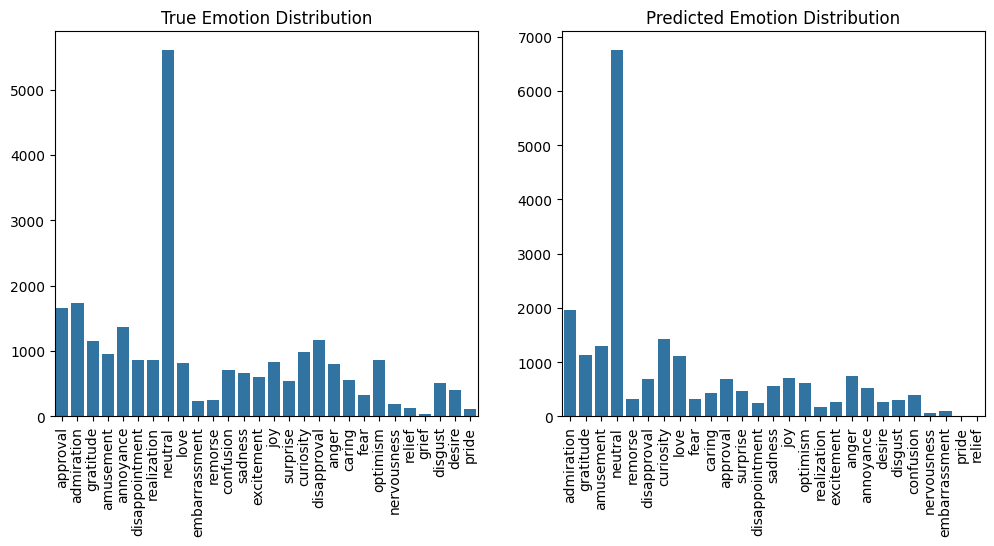

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Flatten all true emotions into a single list
all_true_emotions = [id2label[i] for row in all_labels for i, val in enumerate(row) if val == 1]
all_pred_emotions = [id2label[i] for row in all_preds for i, val in enumerate(row) if val == 1]

# Count frequency
true_counts = Counter(all_true_emotions)
pred_counts = Counter(all_pred_emotions)

# Plot side by side
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(x=list(true_counts.keys()), y=list(true_counts.values()))
plt.xticks(rotation=90)
plt.title("True Emotion Distribution")

plt.subplot(1,2,2)
sns.barplot(x=list(pred_counts.keys()), y=list(pred_counts.values()))
plt.xticks(rotation=90)
plt.title("Predicted Emotion Distribution")

plt.show()


**Step 13.3 Positive/Negative/Neutral Split**

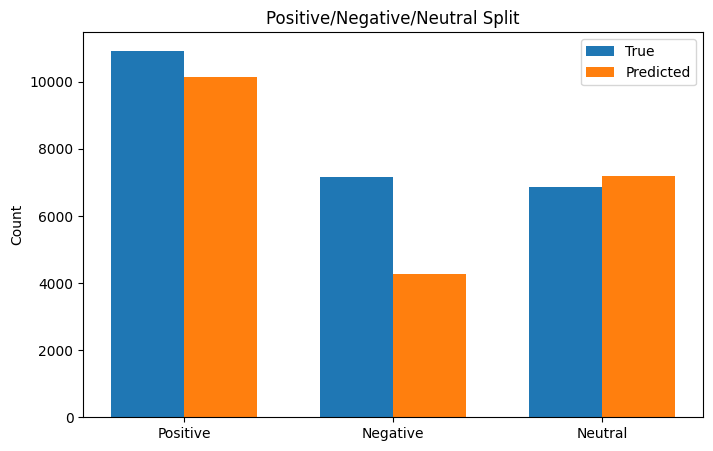

In [44]:
# Flatten group-level labels
true_groups = [g for row in grouped_labels for g in row]
pred_groups = [g for row in grouped_preds for g in row]

true_group_counts = Counter(true_groups)
pred_group_counts = Counter(pred_groups)

# Bar chart
plt.figure(figsize=(8,5))
x = ["Positive", "Negative", "Neutral"]

true_vals = [true_group_counts[g] for g in x]
pred_vals = [pred_group_counts[g] for g in x]

bar_width = 0.35
plt.bar([i - bar_width/2 for i in range(len(x))], true_vals, bar_width, label="True")
plt.bar([i + bar_width/2 for i in range(len(x))], pred_vals, bar_width, label="Predicted")

plt.xticks(range(len(x)), x)
plt.ylabel("Count")
plt.title("Positive/Negative/Neutral Split")
plt.legend()
plt.show()


**Step 14: Saving & Pushing to Hugging Face**

In [38]:
!pip install huggingface_hub


In [39]:
from huggingface_hub import notebook_login

notebook_login()


In [45]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Reloading best model
model = AutoModelForSequenceClassification.from_pretrained("./emotion_model", num_labels=28)
tokenizer = AutoTokenizer.from_pretrained("./emotion_model")

# Saving to Hugging Face Hub
model.push_to_hub("Aribasyed/goemotions-distilbert-model")
tokenizer.push_to_hub("Aribasyed/goemotions-distilbert-model")


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpioek2wtl/model.safetensors    :   0%|          | 8.13kB /  268MB            

CommitInfo(commit_url='https://huggingface.co/Aribasyed/goemotions-distilbert-model/commit/2aa9d748d5b8c90f16e1a871395eb7da16f1f917', commit_message='Upload tokenizer', commit_description='', oid='2aa9d748d5b8c90f16e1a871395eb7da16f1f917', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Aribasyed/goemotions-distilbert-model', endpoint='https://huggingface.co', repo_type='model', repo_id='Aribasyed/goemotions-distilbert-model'), pr_revision=None, pr_num=None)

In [46]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_path = "./emotion_model"  # folder where you unzip your ZIP
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)


In [48]:
import shutil

# 1. Save model + tokenizer into a folder
model.save_pretrained("emotion_model")
tokenizer.save_pretrained("emotion_model")

# 2. Zip the folder
shutil.make_archive("emotion_model", 'zip', "emotion_model")

# 3. Download ZIP to your local device
from google.colab import files
files.download("emotion_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>